# Essentials

Notebook where I produce useful fancy plots to showcase my results and analysis in my thesis. 

In [20]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d
from jax.scipy.special import betainc

from pydd.analysis import get_match_pads
from pydd.binary import get_m_1, get_f_isco, get_m_2
from scipy.integrate import quad, solve_ivp, simps, cumulative_trapezoid

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner
from scipy.interpolate import griddata
from scipy.stats import scoreatpercentile
from scipy.integrate import cumulative_trapezoid, cumulative_simpson
from scipy.special import hyp2f1

In [21]:
import environments_handy_functions

# Reload libraries (in case you change something)
import importlib
importlib.reload(environments_handy_functions)

from environments_handy_functions import (
    myVacuumBinary, myAccretionDisk, myDarkMatter, myCombination,
get_r_s, 
get_rho_s, 
phase_f_cumul, 
derivative_phase_effective_dm, 
myget_c_f, 
get_xi, 
get_c_f, 
phase_f, 
hyperbolic_function, 
f_1yr)

from pydd.binary import (StaticDress, 
                         Phi_to_c,
                         _Phi_to_c_indef_s, 
                         _Phi_to_c_indef_d,
                         _Phi_to_c_indef_v, 
                         _Phi_to_c_indef_a, 
                        DynamicDress, 
                        VacuumBinary, 
                        AccretionDisk)

In [3]:
G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
c = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s

In [4]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "14"

In [5]:
# Fix parameters:

m1 = 1e5 * MSUN 
m2 = 10 * MSUN 
q = m2/m1
M_tot = m1 + m2
mu = m1 * m2 / M_tot
chirp_mass = (m1 * m2)**(3/5) / (M_tot)**(1/5)

# Fix environments:

# Spike

rho6 = 1.17e17 * MSUN / PC**3
r6 =  PC / 1e6
gammas = 7/3
epsv = 0.58
logL = np.log(1 / q**(1/2))

# Accretion disk

r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5e10 / Mach**2
alpha = -1/2

In [6]:
# define different envs

_AD = myAccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=1, 
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=chirp_mass)

_VB = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=100e6 * PC, 
    chirp_mass=chirp_mass)

_DM = myDarkMatter(m1=m1, 
    m2=m2, 
    dist=100e6 * PC, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv, 
    chirp_mass=chirp_mass)

In [7]:
# Build grid of vals

f_LISA = 1e-4 # Hz
r_max = _VB.radius(f_LISA)

r_isco = 6 * m1 * G / C**2
f_isco = _VB.frequency(r_isco)

print('isco frequency', f_isco)

# set grid of radial distances
r_grid = np.linspace(r_isco, r_max, int(1e3))

freqs = _VB.frequency(r_grid)

isco frequency 0.04397229680540114


# Dark matter VS accretion disks:

In [8]:
rho_6_i_LARGE = np.logspace(14, 18, 100)

In [25]:
dark_matter_bench = [myDarkMatter(
    m1=m1, 
    m2=m2, 
    dist=100e6 * PC, 
    q=q, 
    gammas=gammas, 
    rho6=rho * MSUN / PC**3, 
    r6=r6, 
    epsv=epsv, 
    chirp_mass=chirp_mass
)for rho in rho_6_i_LARGE]

dark_matter_ref = myDarkMatter(
    m1=m1, 
    m2=m2, 
    dist=100e6 * PC, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv, 
    chirp_mass=chirp_mass
)

accretion_disk = myAccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=1, 
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=chirp_mass)

vacuum = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=100e6 * PC, 
    chirp_mass=chirp_mass)

combo = myCombination(m1=m1, 
                        m2=m2, 
                        dist=100e6 * PC, 
                        mach=Mach, 
                        sigma0=sigma0,
                        alpha = alpha,
                        r0=r0,
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv, 
                        chirp_mass=chirp_mass)

In [29]:
# Calculate phase to coalescence

phi_to_c_dm = [phase_f_cumul(freqs, dark_matter_bench[i]) for i in range(0, len(dark_matter_bench))]
phi_to_c_dm_ref = phase_f_cumul(freqs, dark_matter_ref)
phi_to_c_acc = phase_f_cumul(freqs, accretion_disk)
phi_to_c_vacuum = phase_f_cumul(freqs, vacuum)
phi_to_c_combo = phase_f_cumul(freqs, combo)

In [30]:
dephase_dm = [(phi_to_c_dm[i] - phi_to_c_vacuum) for i in range(0, len(phi_to_c_dm))]
dephase_dm_ref = phi_to_c_dm_ref - phi_to_c_vacuum
dephase_acc = phi_to_c_acc - phi_to_c_vacuum
dephase_combo = phi_to_c_combo - phi_to_c_vacuum

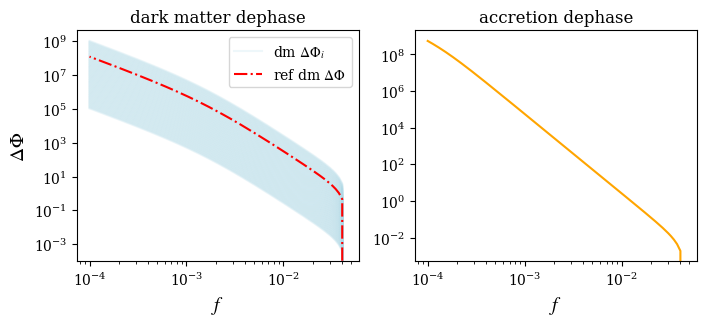

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for i in range(0, len(dephase_dm)-1): 
    axes[0].loglog(freqs, dephase_dm[i], c='lightblue', alpha=0.2)
    
axes[0].loglog(freqs, dephase_dm[-1], c='lightblue', label='dm $\Delta\Phi_i$', alpha=0.2)
axes[0].loglog(freqs, dephase_dm_ref, c='red', label='ref dm $\Delta\Phi$', linestyle='-.')
axes[1].loglog(freqs, dephase_acc, c='orange', label='acc $\Delta\Phi$')

axes[0].set_xlabel('$f$')
axes[0].set_ylabel('$\Delta\Phi$')
axes[1].set_xlabel('$f$')

axes[1].set_title('accretion dephase')
axes[0].set_title('dark matter dephase')

axes[0].legend()
#axes[1].legend()
plt.show()

In [50]:
# find f1yr 

f1yr = f_1yr(combo, 1 * YR)

In [51]:
print('f 1yr = ', f1yr/f_isco, ' f_isco')

f 1yr =  0.1252503833291989  f_isco


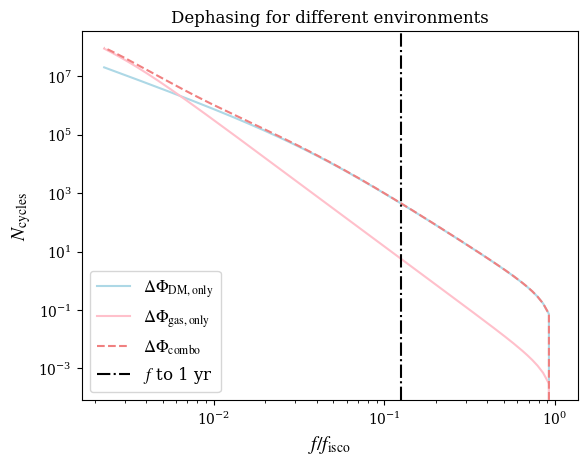

In [52]:
plt.loglog(freqs / f_isco, dephase_dm_ref/(2 * np.pi), c='lightblue', alpha=1, label=r'$\Delta\Phi_{\mathrm{DM, only}}$')
plt.loglog(freqs / f_isco, dephase_acc/(2 * np.pi), c='pink', alpha=1, label='$\Delta\Phi_{\mathrm{gas, only}}$')
plt.loglog(freqs / f_isco, dephase_combo/(2 * np.pi), c='lightcoral', linestyle='--', alpha=1, label=r'$\Delta\Phi_{\mathrm{combo}}$')

plt.title(r'Dephasing for different environments', fontsize=12)
plt.xlabel('$f/f_{\mathrm{isco}}$')
plt.ylabel('$N_{\mathrm{cycles}}$')

plt.axvline(x=f1yr/f_isco, label='$f$ to 1 yr', c='black', linestyle='-.')

# Adjust legend
plt.legend(fontsize='large', loc='lower left')
plt.savefig('figures/dephase_all.png')
plt.show()

In [53]:
def find_dm_benchmark(dephase_dm_array, dephase_acc, rho_array, f_ref):
    
    '''Finds the benchmark value for dark matter fixing the reference frequency, using two dephasings.'''
    
    i = np.where(freqs < f_ref)[0][0]
    delta = np.array([np.abs(dephase_dm_array[j][i] - dephase_acc[i]) for j in range(0, len(dephase_dm_array))])     
    i_min = np.where(delta == np.min(delta))[0][0]
    
    return i_min, rho_array[i_min]

In [54]:
# find threshold

imax, rho_max = find_dm_benchmark(dephase_dm, dephase_acc, rho_6_i_LARGE, f1yr)
imin, rho_min = find_dm_benchmark(dephase_dm, dephase_acc, rho_6_i_LARGE, f_isco)

In [55]:
# results

print('rho benchmark = [', f'{rho_min:.7e}, {rho_max:.7e}] M_sun / pc^3')

rho benchmark = [ 4.8626016e+14, 1.4849683e+15] M_sun / pc^3


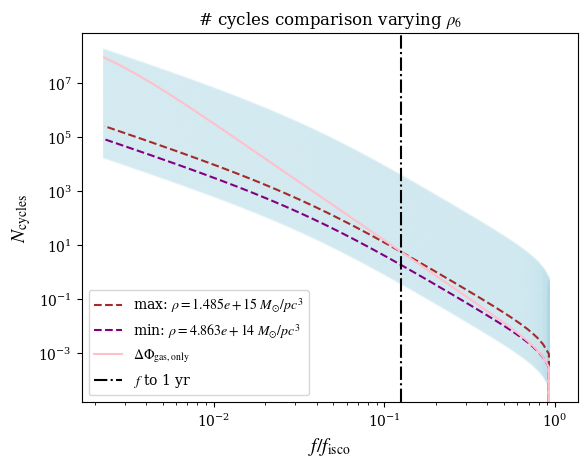

In [56]:
for i in range(0, len(dephase_dm)):
    plt.loglog(freqs / f_isco, dephase_dm[i]/(2 * np.pi), c='lightblue', alpha=0.3)

plt.loglog(freqs / f_isco, dephase_dm[imax]/(2 * np.pi), c='brown', linewidth=1.5, label=fr'max: $\rho = {rho_max:.3e} \ M_{{\odot}} / pc^3$', linestyle='--')
plt.loglog(freqs / f_isco, dephase_dm[imin]/(2 * np.pi), c='purple', linewidth=1.5, label=fr'min: $\rho = {rho_min:.3e} \ M_{{\odot}} / pc^3$', linestyle='--')
plt.loglog(freqs / f_isco, dephase_acc/(2 * np.pi), c='pink', linewidth=1.5, label='$\Delta\Phi_{\mathrm{gas, only}}$')

plt.title(r'# cycles comparison varying $\rho_6$', fontsize=12)
plt.xlabel('$f/f_{\mathrm{isco}}$')
plt.ylabel('$N_{\mathrm{cycles}}$')

plt.axvline(x=f1yr/f_isco, label='$f$ to 1 yr', c='black', linestyle='-.')

# Adjust legend
plt.legend(fontsize='medium', loc='lower left')
plt.savefig('figures/dephase_comparison_dm_acc.png')
plt.show()

First question: how does the accretion disk build up to become dm-like?

# Find energy ratio

In [19]:
# some constants we need 

rho_sp = get_rho_s(rho6, m1, gammas)
r_sp = get_r_s(m1, rho_sp, gammas)

In [20]:
# dot r extraction

r_dot_acc = accretion_disk.dot_r_acc(r_grid) 
r_dot_dm_s = dark_matter_ref.dot_r_dm_s(r_grid) 
r_dot_dm_eff = dark_matter_ref.dot_r_dm_eff(r_grid) - dark_matter_ref.Binary_init.dot_r_gw(r_grid)
r_dot_gw = vacuum.dot_r_gw(r_grid)

In [21]:
# find pydd environments

_pydd_DM = StaticDress(PN=0,
    gamma_s=gammas, 
    c_f=myget_c_f(m1, m2, rho_sp, gammas, logL, epsv, r_sp), # get_c_f(m1, m2, rho_sp, gammas) 
    M_chirp=chirp_mass, 
    Phi_c=0,
    tT_c=0,
    dL=100e6 * PC, 
    f_c=f_isco)

_pydd_DM_eff = DynamicDress(PN=0,
    gamma_s=gammas, 
    rho_6 = rho6, 
    M_chirp=chirp_mass, 
    q = q,
    Phi_c=0,
    tT_c=0,
    dL=100e6 * PC, 
    f_c=f_isco)

_pydd_ACC = AccretionDisk(0,
        sigma0 * Mach**2,
        -1, 
        chirp_mass,
        q,
        0,
        tT_c=0,
        dL=np.array(100e6 * PC), 
        f_c=f_isco,
    )

_pydd_VAC = VacuumBinary(PN=0,
    M_chirp = chirp_mass, 
    Phi_c=0, 
    tT_c=0, 
    dL=100e6 * PC, 
    f_c=f_isco)

# Consistency checks

## 1) $d\Phi/d\text{f}$

Comparison between phase derivatives:

In [22]:
def dphi_df(r):
    
    '''My version of the phase derivative, straight from library.'''
    
    phase_vacuum = vacuum.vacuum_phase(r)
    dphase_vacuum_df = vacuum.dvacuum_phase_df(r)
    
    freqs = vacuum.frequency(r)
    rho_s = get_rho_s(dark_matter_ref.rho6, dark_matter_ref.Binary_init.m1, dark_matter_ref.gammas)
    r_sp = get_r_s(dark_matter_ref.Binary_init.m1, rho_s, dark_matter_ref.gammas)
    
    beta = 0.8162599280541165
    alpha_1 = 1.441237217113085
    alpha_2 = 0.4511442198433961
    xi = -0.49709119294335674
    gamma_r = 1.4395688575650551
    
    m_sun = MSUN
    
    f_b = beta * (dark_matter_ref.Binary_init.m1 / (1e3 * m_sun))**(-alpha_1) * (dark_matter_ref.Binary_init.m2 / (m_sun))**alpha_2 * (1 + xi * np.log(dark_matter_ref.gammas/gamma_r))
    
    f_t = f_b
    y = freqs / f_t
    #cf = get_c_f(dark_matter_ref.Binary_init.m1, dark_matter_ref.Binary_init.m2, rho_s, dark_matter_ref.gammas)
    cf = myget_c_f(dark_matter_ref.Binary_init.m1, dark_matter_ref.Binary_init.m2, rho_s, dark_matter_ref.gammas, dark_matter_ref.logL, dark_matter_ref.epsv, r_sp)
    gamma_e = 5/2
    theta = 5 / (2 * gamma_e)
    Lambda = (11 - 2 * (dark_matter_ref.gammas + gamma_e)) / 3
    f_eq = cf**(3 / (11 - 2 * dark_matter_ref.gammas))
    eta = (5 + 2 * gamma_e) / (2 * (8 - dark_matter_ref.gammas)) * (f_eq / f_b)**((11 - 2 * dark_matter_ref.gammas)/3)
    
    h2f1 = hyperbolic_function(y, theta)
    dh2f1_dy = 5/(3*y) * (-1/(1+y**(-5/(3*theta))) + h2f1)
    
    #   Derivative terms
    dy_df = 1 / f_t
    #dy_power_term = -Lambda * y**(-Lambda - 1) * dy_df
    #dh2f1_term = dh2f1_dy * dy_df
    
    ## Final derivative :
    dphase_tot_df = dphase_vacuum_df - dphase_vacuum_df * eta * y**(-Lambda) + Lambda * y**(-Lambda-1) * dy_df * eta * phase_vacuum + dphase_vacuum_df * eta * y**(-Lambda) * h2f1 - Lambda * y**(-Lambda -1) * dy_df * h2f1 * eta * phase_vacuum + phase_vacuum * eta * y**(-Lambda) * dh2f1_dy * dy_df
    
    #(1 + eta * (-1 + h2f1) * y**(-Lambda)) * dphase_vacuum_df + 1/3 * eta * phase_vacuum * y**(-1-Lambda) * (3 * Lambda + (5 - 3 * Lambda) * h2f1 - 5/(1 + y**(-5/(3*theta)))) * dy_df
    #dphase_vacuum_df * (1 - eta * y**(-Lambda) * (1 - h2f1)) + phase_vacuum * (-eta * dy_power_term * (1 - h2f1) + eta * y**(-Lambda) * dh2f1_term)
    
    return dphase_tot_df

In [23]:
def Mc(m1, m2):
    return ((m1 * m2)**(3/5))/(m1 + m2)**(1/5)

def rsc(m1, m2):
    return 2 * G * (m1 + m2)/(c**2)

def Lamb(m1,m2):
    return np.sqrt(m1/m2)

ge = 5/2
zeta = 0.58
alpha1 = 1.441237217113085
alpha2 = 0.4511442198433961
beta = 0.8162599280541165
rie = -0.49709119294335674
gr = 1.4395688575650551

def dphi_df_pip(f, m1, m2, gsp, rhosp): #this is the phase INCLUDING vacuum term
    
    '''Pippa's version of the phase derivative.'''
    
    fb = beta * (m1/(1000 * MSUN))**-alpha1 * (m2/MSUN)**alpha2 * (1 + (rie * np.log(gsp/gr)))
    y = f/fb
    theta = 5/(2 * ge)
    l = (11 - 2 * (gsp + ge))/3
    yt = 1 + y**(5/(3*theta))
    
    rsp = ((3 - gsp) * 0.2**(3 - gsp) * m1 / (2 * np.pi * rhosp))**(1/3)
    
    cf = 5 * c**5 * np.pi**(2*(gsp - 4)/3) * G**(-(2 + gsp)/3) * \
    (m1 + m2)**((1-gsp)/3)* rsp**gsp * 0.58 * rhosp * np.log(Lamb(m1,m2))/(8*m1**2)
    
    feq = cf**(3/(11 - 2*gsp))
    
    eta = ((5 + 2 * ge)*(feq/fb)**((11 - 2 * gsp)/3))/(2 * (8 - gsp))

    
    return (-1/(48 * f * yt * np.pi**(5/3))) * y**-l * (c**3/(f * G * Mc(m1,m2)))**(5/3)\
            * (5 * yt * y**l - eta * (5 + (3 * yt * l)) + \
            (3 * yt * eta * l * hyp2f1(1,theta,1+theta,-y**(-5/(3*theta)))))

def dphidf_v(f, m1, m2):
    '''Pippa's version of the vacuum phase derivative.'''
    return -5*(c**3/(f*G*Mc(m1,m2)))**(5/3)/(48 * f * np.pi**(5/3))

def rdot_dd(f, m1, m2, gsp, rhosp): # this is rdot with rdot_GW subtracted off
    '''Pippa's version of the separation derivative.'''
    return -rdot_GW(f,m1,m2) -(4/3) * G*(m1+m2) * np.pi**(1/3) * (G * (m1+m2)/(f**2))**(-2/3)* f**-2  / dphidf(f, m1, m2, gsp, rhosp)

def Edot_dd(r, m1, m2, gsp, rhosp):
    '''Pippa's version of the energy derivative.'''
    fgw = np.sqrt(G * (m1 + m2)/(r**3))/np.pi
    return rdot_dd(fgw, m1, m2, gsp, rhosp) * G * m1 * m2 / (2*r**2)

In [24]:
dphi_df_mine = dphi_df(r_grid)
dphi_df_pippa = dphi_df_pip(freqs, m1, m2, gammas, rho_sp)

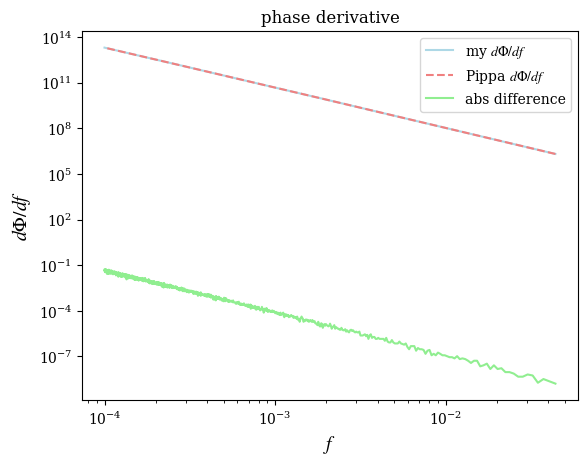

In [25]:
plt.loglog(freqs, dphi_df_mine, label='my $d\Phi/df$',c='lightblue')
plt.loglog(freqs, -dphi_df_pippa, linestyle='--', label='Pippa $d\Phi/df$', c='lightcoral')
plt.loglog(freqs, np.abs(-dphi_df_pippa-dphi_df_mine), c='lightgreen', label='abs difference')

plt.xlabel('$f$')
plt.ylabel('$d\Phi/df$')

plt.title('phase derivative')
plt.legend()
plt.show()

In [26]:
def fit(f): 
    
    '''Fit residuals from difference of two versions.'''
    
    beta = 0.8162599280541165
    alpha_1 = 1.441237217113085
    alpha_2 = 0.4511442198433961
    xi = -0.49709119294335674
    gamma_r = 1.4395688575650551
    
    m_sun = MSUN
    
    rho_s = get_rho_s(dark_matter_ref.rho6, dark_matter_ref.Binary_init.m1, dark_matter_ref.gammas)
    r_s = get_r_s(dark_matter_ref.Binary_init.m1, rho_s, dark_matter_ref.gammas)
    
    f_b = beta * (dark_matter_ref.Binary_init.m1 / (1e3 * m_sun))**(-alpha_1) * (dark_matter_ref.Binary_init.m2 / (m_sun))**alpha_2 * (1 + xi * np.log(dark_matter_ref.gammas/gamma_r))
    
    f_t = f_b
    y = freqs / f_t
    cf = get_c_f(dark_matter_ref.Binary_init.m1, dark_matter_ref.Binary_init.m2, rho_s, dark_matter_ref.gammas)
    #cf = myget_c_f(self.Binary_init.m1, self.Binary_init.m2, rho_s, self.gammas, self.logL, self.epsv, r_s)
    gamma_e = 5/2
    theta = 5 / (2 * gamma_e)
    Lambda = (11 - 2 * (dark_matter_ref.gammas + gamma_e)) / 3
    f_eq = cf**(3 / (11 - 2 * dark_matter_ref.gammas))
    eta = (5 + 2 * gamma_e) / (2 * (8 - dark_matter_ref.gammas)) * (f_eq / f_b)**((11 - 2 * dark_matter_ref.gammas)/3)
    
    return 1/16 * 5/(3 * f) * eta * (c**3 / (G * f * np.pi * chirp_mass))**(5/3) * y**(-Lambda) * (1 - 1/(1+y**(-5/(3 * theta))) - 1/(1+y**(5/(3*theta))))

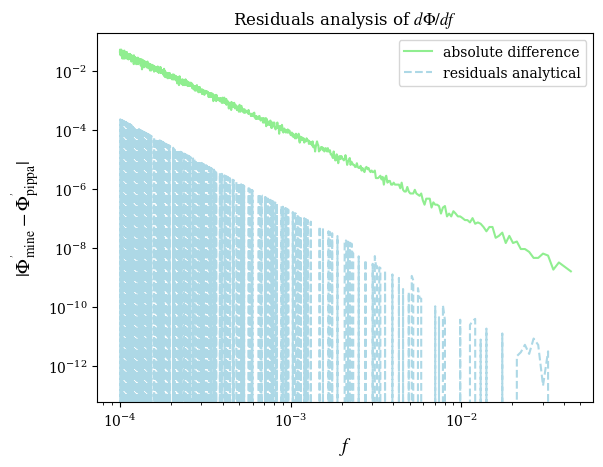

In [27]:
plt.loglog(freqs, np.abs(- dphi_df_mine - dphi_df_pippa), label='absolute difference', c='lightgreen')
plt.loglog(freqs, fit(freqs), linestyle='--', label='residuals analytical', c='lightblue')

plt.xlabel('$f$')
plt.ylabel('$|\Phi_{\mathrm{mine}}^{\'} - \Phi_{\mathrm{pippa}}^{\'}|$')

plt.title('Residuals analysis of $d\Phi/df$')
plt.legend()
plt.show()

## 2) $\Phi(f)$

In [28]:
def df_dt_static(f, darkmatter):
    '''Just to check dark matter static profile phase to coalescence.'''
    r = darkmatter.Binary_init.radius(f)
    df_dr = darkmatter.Binary_init.df_dr(r)
    dot_r = darkmatter.dot_r_dm_s(r) + darkmatter.Binary_init.dot_r_gw(r)
    return df_dr * dot_r

def phase_f_cumul_static(f, darkmatter):
    '''Convenience function just for static DM calculation.'''
    to_integrate = 2 * np.pi * df_dt_static(f, darkmatter)**(-1) * f
    phase = cumulative_trapezoid(to_integrate, f, initial=0)
    return phase

In [29]:
# find pydd phi_to_c

phi_to_c_dm_ref_PYDD = -Phi_to_c(freqs, _pydd_DM_eff)
phi_to_c_acc_PYDD = -Phi_to_c(freqs, _pydd_ACC)
phi_to_c_vac_PYDD = -Phi_to_c(freqs, _pydd_VAC)

# find combo and static

phi_to_c_combo = phase_f_cumul(freqs, combo)
phi_to_c_dm_s = phase_f_cumul_static(freqs, dark_matter_ref)

/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_83475/1300416028.py:3: RuntimeWarning: invalid value encountered in divide
  axes[0].loglog(freqs, np.abs(phi_to_c_dm_ref-phi_to_c_dm_ref_PYDD)/np.abs(phi_to_c_dm_ref_PYDD))
/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_83475/1300416028.py:8: RuntimeWarning: invalid value encountered in divide
  axes[1].loglog(freqs, np.abs(phi_to_c_acc-phi_to_c_acc_PYDD)/np.abs(phi_to_c_acc_PYDD))
/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_83475/1300416028.py:12: RuntimeWarning: invalid value encountered in divide
  axes[2].loglog(freqs, np.abs(phi_to_c_vacuum-phi_to_c_vac_PYDD)/np.abs(phi_to_c_vac_PYDD))


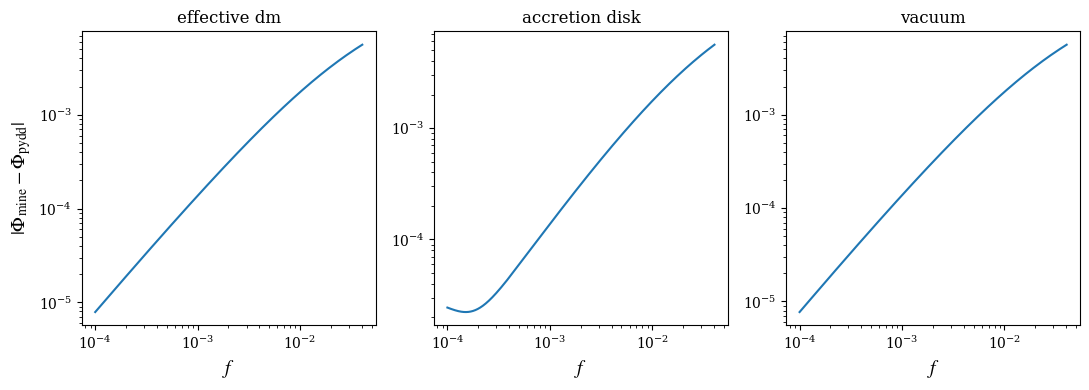

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(11,4))

axes[0].loglog(freqs, np.abs(phi_to_c_dm_ref-phi_to_c_dm_ref_PYDD)/np.abs(phi_to_c_dm_ref_PYDD))
axes[0].set_xlabel('$f$')
axes[0].set_ylabel('$|\Phi_{\mathrm{mine}} - \Phi_{\mathrm{pydd}}|$')
axes[0].set_title('effective dm')

axes[1].loglog(freqs, np.abs(phi_to_c_acc-phi_to_c_acc_PYDD)/np.abs(phi_to_c_acc_PYDD))
axes[1].set_xlabel('$f$')
axes[1].set_title('accretion disk')

axes[2].loglog(freqs, np.abs(phi_to_c_vacuum-phi_to_c_vac_PYDD)/np.abs(phi_to_c_vac_PYDD))
axes[2].set_xlabel('$f$')
axes[2].set_title('vacuum')

plt.tight_layout()
plt.show()

Okay for the phase to coalescence. Still not sure about the result for the dephase then, we try and see below.

## 2) $\Delta\Phi(f)$

In [31]:
# compute dephase and absolute difference separately

dephase_dm_ref_PYDD = phi_to_c_dm_ref_PYDD - phi_to_c_vac_PYDD
dephase_acc_PYDD = phi_to_c_acc_PYDD - phi_to_c_vac_PYDD

dephase_combo = phi_to_c_combo - phi_to_c_vacuum
dephase_dm_s = phi_to_c_dm_s - phi_to_c_vacuum

abs_dm_dephase = np.abs(dephase_dm_ref - dephase_dm_ref_PYDD)/np.abs(dephase_dm_ref_PYDD)
abs_acc_dephase = np.abs(dephase_acc - dephase_acc_PYDD)/np.abs(dephase_acc_PYDD)

/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_83475/2385997607.py:9: RuntimeWarning: invalid value encountered in divide
  abs_dm_dephase = np.abs(dephase_dm_ref - dephase_dm_ref_PYDD)/np.abs(dephase_dm_ref_PYDD)
/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_83475/2385997607.py:10: RuntimeWarning: invalid value encountered in divide
  abs_acc_dephase = np.abs(dephase_acc - dephase_acc_PYDD)/np.abs(dephase_acc_PYDD)


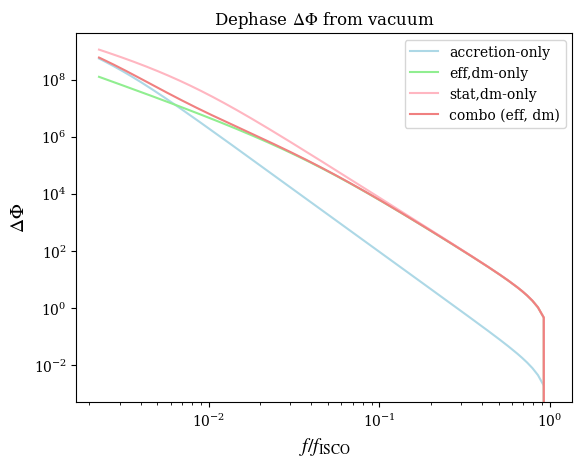

In [32]:
# plot dephase

plt.loglog(freqs/f_isco, dephase_acc, c='lightblue', label='accretion-only')
plt.loglog(freqs/f_isco, dephase_dm_ref, c='lightgreen', label='eff,dm-only')
plt.loglog(freqs/f_isco, dephase_dm_s, c='lightpink', label='stat,dm-only')
plt.loglog(freqs/f_isco, dephase_combo, c='lightcoral', label='combo (eff, dm)')
plt.xlabel('$f/f_{\mathrm{ISCO}}$')
plt.ylabel('$\Delta\Phi$')
plt.title('Dephase $\Delta\Phi$ from vacuum')

plt.legend()
plt.show()

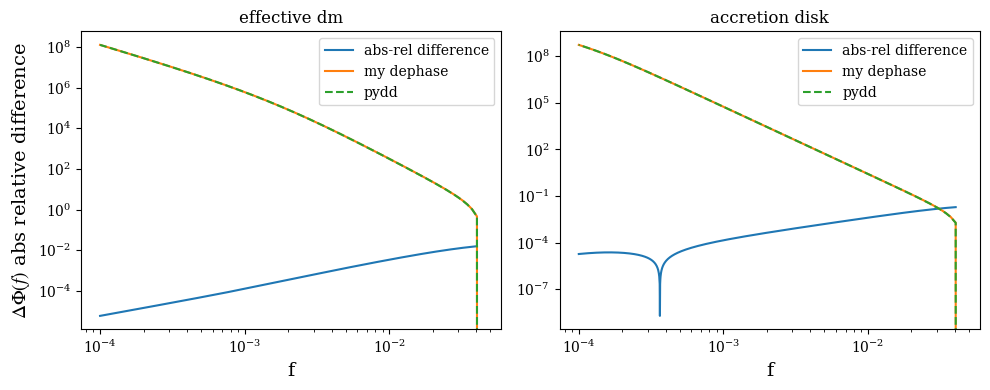

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].loglog(freqs, abs_dm_dephase, label='abs-rel difference')
axes[0].loglog(freqs, dephase_dm_ref, label='my dephase')
axes[0].loglog(freqs, dephase_dm_ref_PYDD, linestyle='--', label='pydd')
axes[0].set_xlabel('f')
axes[0].set_ylabel('$\Delta\Phi(f)$ abs relative difference')
axes[0].set_title('effective dm')
axes[0].legend(loc='upper right')

axes[1].loglog(freqs, abs_acc_dephase, label='abs-rel difference')
axes[1].loglog(freqs, dephase_acc, label='my dephase')
axes[1].loglog(freqs, dephase_acc_PYDD, linestyle='--', label='pydd')
axes[1].set_xlabel('f')
axes[1].set_title('accretion disk')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

## 3) Energy ratio

In [34]:
with open('edot_results.pkl', 'rb') as f:
    edot_pippa = pickle.load(f)
    
with open('edot_results_RADII.pkl', 'rb') as f:
    edot_pippa_r = pickle.load(f)

In [35]:
f

<_io.BufferedReader name='edot_results_RADII.pkl'>

In [36]:
dot_r_dm_eff = dark_matter_ref.dot_r_dm_eff(r_grid) - vacuum.dot_r_gw(r_grid)
dot_r_acc = accretion_disk.dot_r_acc(r_grid)
dot_r_combo = combo.dot_r_combo(r_grid) - vacuum.dot_r_gw(r_grid)
dot_r_vacuum = vacuum.dot_r_gw(r_grid)

Since $\dot{E} \propto \dot{r}$ we can do the ratio directly:

In [37]:
edot_dm_eff_vac = dot_r_dm_eff/dot_r_vacuum
edot_combo_vac = dot_r_combo/dot_r_vacuum
edot_acc_vac = dot_r_acc/dot_r_vacuum

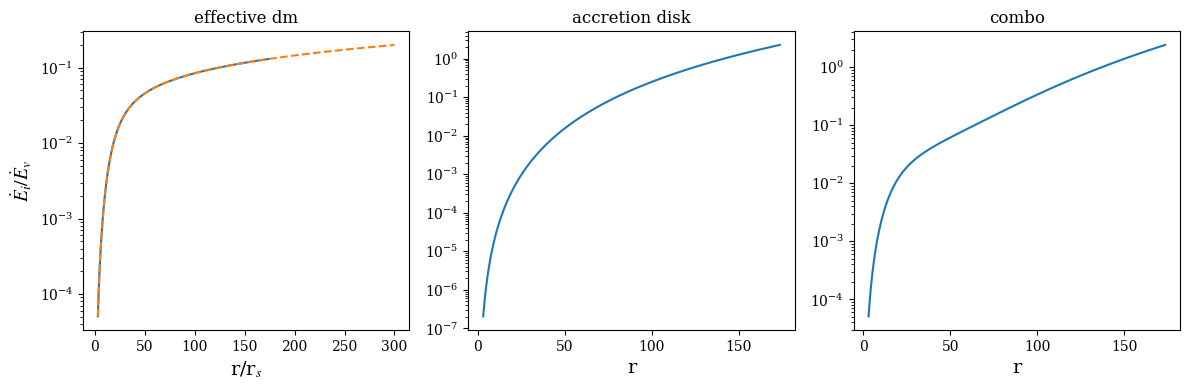

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

axes[0].semilogy(r_grid/r_s, edot_dm_eff_vac)
axes[0].semilogy(edot_pippa_r, edot_pippa, linestyle='--')
axes[0].set_xlabel('r/r$_s$')
axes[0].set_ylabel('$\dot{E}_i/\dot{E}_v$')
axes[0].set_title('effective dm')

axes[1].semilogy(r_grid/r_s, edot_acc_vac)
axes[1].set_xlabel('r')
axes[1].set_title('accretion disk')

axes[2].semilogy(r_grid/r_s, edot_combo_vac)
axes[2].set_xlabel('r')
axes[2].set_title('combo')

plt.tight_layout()
plt.show()

## 4) $\dot{r}_\mathrm{dm, eff}$ 

Comparison between phase derivatives: 

In [39]:
dr = dark_matter_ref.dot_r_dm_eff(r_grid)

dfdr = dark_matter_ref.Binary_init.df_dr(r_grid)
dfdt = 2 * np.pi * freqs / (dphi_df_pip(freqs, m1, m2, gammas, rho_sp))

r_dot_dm_eff_pippa = dfdr**-1 * dfdt

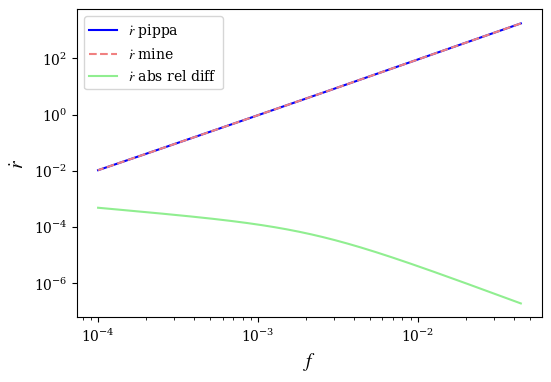

In [40]:
plt.figure(figsize=(6, 4))

plt.loglog(freqs, r_dot_dm_eff_pippa, c='blue', linestyle='-', label='$\dot{r}$ pippa')
plt.loglog(freqs, -dr, c='lightcoral', linestyle='--', label='$\dot{r}$ mine')
plt.loglog(freqs, np.abs(-dr -r_dot_dm_eff_pippa)/np.abs(r_dot_dm_eff_pippa), c='lightgreen', linestyle='-', label='$\dot{r}$ abs rel diff')

plt.xlabel('$f$')
plt.ylabel('$\dot{r}$')

plt.legend()
plt.show()